# Classificação de Lesões Cervicais a partir de CSV

## 1. Configuração do Ambiente e Carregamento de Dados

In [36]:
import os
import shutil
from pathlib import Path
import random   
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
# Caminhos para os arquivos de dados (usando barras normais para compatibilidade)
train_csv_path = 'c:/Users/IA/Desktop/citology pipeline Train/train_data.csv'
val_csv_path = 'c:/Users/IA/Desktop/citology pipeline Train/val_data.csv'
test_csv_path = 'c:/Users/IA/Desktop/citology pipeline Train/test_data.csv'

# Carregar os dataframes
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

print("Dados de Treino:")
print(train_df.head())
print("\nDados de Validação:")
print(val_df.head())
print("\nDados de Teste:")
print(test_df.head())

Dados de Treino:
  lesion_type                          image_path
0       LISIL  Dataset/Tile/LISIL/NL_28_ (12).jpg
1       LISIL    Dataset/Tile/LISIL/parab_072.bmp
2       LISIL          Dataset/Tile/LISIL/050.bmp
3       LISIL   Dataset/Tile/LISIL/NL_37_ (9).jpg
4       LISIL      Dataset/Tile/LISIL/koi_203.bmp

Dados de Validação:
  lesion_type                        image_path
0       LISIL        Dataset/Tile/LISIL/047.bmp
1       HISIL  Dataset/Tile/HISIL/scc_1 (1).jpg
2       LISIL        Dataset/Tile/LISIL/203.bmp
3       LISIL        Dataset/Tile/LISIL/192.bmp
4       LISIL  Dataset/Tile/LISIL/parab_025.bmp

Dados de Teste:
  lesion_type                         image_path
0       LISIL     Dataset/Tile/LISIL/sup_121.bmp
1       HISIL  Dataset/Tile/HISIL/HSIL_2 (4).jpg
2       LISIL     Dataset/Tile/LISIL/koi_016.bmp
3       LISIL  Dataset/Tile/LISIL/NL_15_ (2).jpg
4       LISIL  Dataset/Tile/LISIL/NL_2_ (14).jpg


## 2. Preparação dos Geradores de Imagens

In [38]:
from random import shuffle


# Configurações
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Parâmetros do modelo

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS_FASE1 = 10
EPOCHS_FASE2 = 20
INITIAL_LR = 1e-4
FINE_TUNE_LR = 1e-5
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

# Diretório base onde as imagens estão localizadas
image_dir = 'c:/Users/IA/Desktop/citology pipeline Train/'
BASE_DIR = Path("c:/Users/IA/Desktop/Dataset Citologia")


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='image_path',
    y_col='lesion_type',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='image_path',
    y_col='lesion_type',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='image_path',
    y_col='lesion_type',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 1159 validated image filenames belonging to 2 classes.
Found 249 validated image filenames belonging to 2 classes.
Found 249 validated image filenames belonging to 2 classes.


c:\Users\IA\miniconda3\envs\train-env\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


## 3. Construção do Modelo (MobileNet)

In [14]:
# base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# base_model.trainable = False

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)

# num_classes = len(train_generator.class_indices)
# predictions = Dense(num_classes, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

In [40]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dropout

def create_mobilenet_model(input_shape=IMG_SIZE + (3,), num_classes=2):
    """Criar modelo MobileNetV2 com transfer learning"""
    
    # Carregar MobileNetV2 pré-treinado (sem o topo)
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Congelar as camadas da base
    base_model.trainable = False
    
    # Adicionar camadas customizadas
    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='sigmoid')
    ])
    
    return model, base_model


In [41]:

# Criar modelo
model, base_model = create_mobilenet_model()

# Compilar modelo
model.compile(
    optimizer=Adam(learning_rate=INITIAL_LR),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

print("Modelo criado e compilado!")
print(f"Número total de camadas: {len(model.layers)}")
print(f"Camadas congeladas: {sum(1 for layer in base_model.layers if not layer.trainable)}")
print(f"Camadas treináveis: {sum(1 for layer in model.layers if layer.trainable)}")

Modelo criado e compilado!
Número total de camadas: 6
Camadas congeladas: 154
Camadas treináveis: 5


In [42]:
# Mostrar resumo do modelo
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                

## 4. Treinamento do Modelo

In [43]:
# EPOCHS = 20

# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // BATCH_SIZE,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // BATCH_SIZE,
#     epochs=EPOCHS
# )

In [44]:
# Callbacks para o treinamento
checkpoint_path = BASE_DIR / "best_model_fase1.h5"

callbacks_fase1 = [
    ModelCheckpoint(
        str(checkpoint_path),
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

print("Iniciando Fase 1: Treinamento do topo customizado...")

history_fase1 = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS_FASE1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks_fase1,
    verbose=1
)

print("Fase 1 concluída!")

Iniciando Fase 1: Treinamento do topo customizado...
Epoch 1/10
37/37 [==============================] - ETA: 0s - loss: 0.5710 - accuracy: 0.7619 - precision_1: 0.7417 - recall_1: 0.7334
Epoch 1: val_loss improved from inf to 0.36765, saving model to c:\Users\IA\Desktop\Dataset Citologia\best_model_fase1.h5
37/37 [==============================] - 58s 2s/step - loss: 0.5710 - accuracy: 0.7619 - precision_1: 0.7417 - recall_1: 0.7334 - val_loss: 0.3677 - val_accuracy: 0.8594 - val_precision_1: 0.8594 - val_recall_1: 0.8594
Epoch 2/10
37/37 [==============================] - ETA: 0s - loss: 0.4293 - accuracy: 0.8568 - precision_1: 0.8448 - recall_1: 0.8550
Epoch 2: val_loss improved from 0.36765 to 0.31250, saving model to c:\Users\IA\Desktop\Dataset Citologia\best_model_fase1.h5
37/37 [==============================] - 53s 1s/step - loss: 0.4293 - accuracy: 0.8568 - precision_1: 0.8448 - recall_1: 0.8550 - val_loss: 0.3125 - val_accuracy: 0.8594 - val_precision_1: 0.8617 - val_recall_1

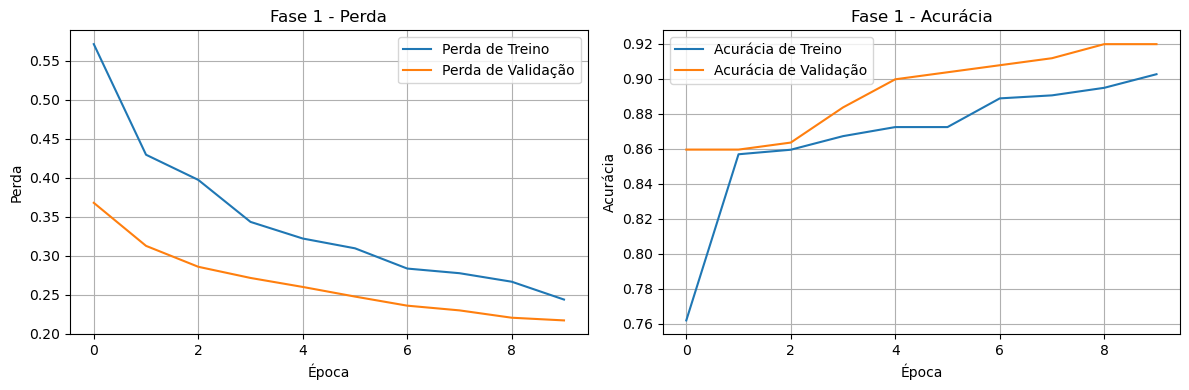

In [45]:
def plot_training_history(history, title="Histórico de Treinamento"):
    """Plotar histórico de treinamento"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plotar perda
    ax1.plot(history.history['loss'], label='Perda de Treino')
    ax1.plot(history.history['val_loss'], label='Perda de Validação')
    ax1.set_title(f'{title} - Perda')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Perda')
    ax1.legend()
    ax1.grid(True)
    
    # Plotar acurácia
    ax2.plot(history.history['accuracy'], label='Acurácia de Treino')
    ax2.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    ax2.set_title(f'{title} - Acurácia')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Acurácia')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_fase1, "Fase 1")

## 5. Avaliação do Modelo

In [6]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples)
print(f'Acurácia no conjunto de teste: {test_acc:.4f}')

249/249 [==============================] - 16s 64ms/step - loss: 0.0688 - accuracy: 0.9719
Acurácia no conjunto de teste: 0.9719


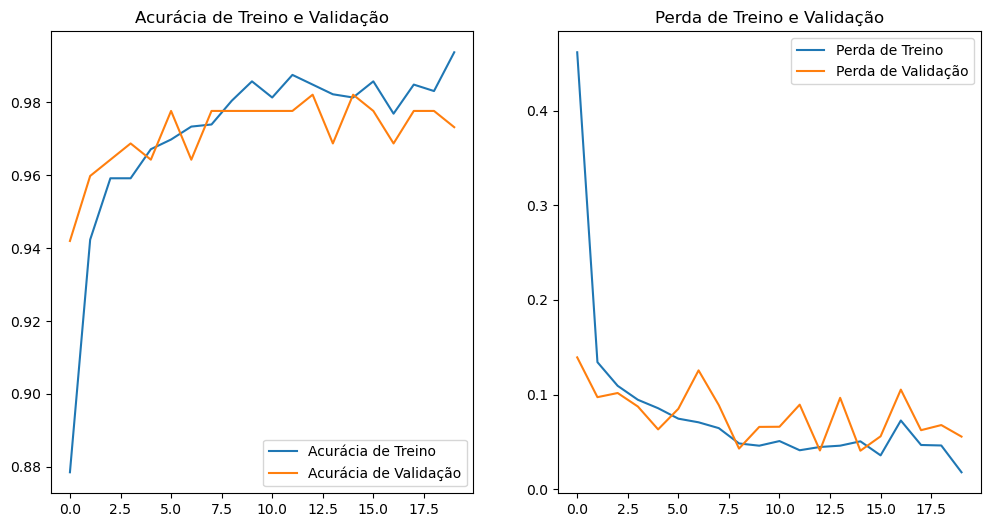

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.show()

249/249 [==============================] - 14s 55ms/step
Matriz de Confusão


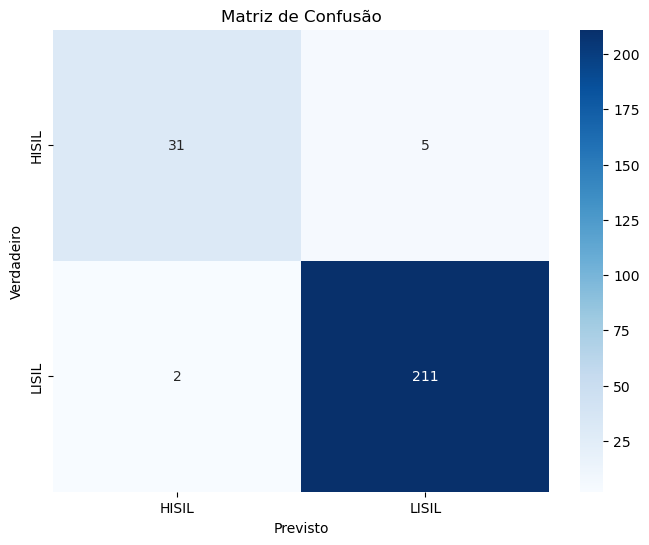


Relatório de Classificação
              precision    recall  f1-score   support

       HISIL       0.94      0.86      0.90        36
       LISIL       0.98      0.99      0.98       213

    accuracy                           0.97       249
   macro avg       0.96      0.93      0.94       249
weighted avg       0.97      0.97      0.97       249



In [9]:
Y_pred = model.predict(test_generator, steps=test_generator.samples)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print('Matriz de Confusão')
cm = confusion_matrix(true_classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

print('\nRelatório de Classificação')
print(classification_report(true_classes, y_pred, target_names=class_labels))